# ***PySPARK***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q http://apache.mirrors.pair.com/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz

In [ ]:
!tar xf spark-3.3.1-bin-hadoop3.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
findspark.find()

'/content/spark-3.3.1-bin-hadoop3'

Una vez tenemos instalado nuestro framework, es momento de crear nuestra variable SparkSession, de la cual parten la mayoría de funcionalidades de SparkSQL

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Pyspark_SQL")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
spark

In [ ]:
!pwd

/content


In [ ]:
import pandas as pd

data_path = '/content/drive/MyDrive/PROYECTO_tokio/'

data = spark.read.options(inferSchema='True',delimiter=',', header=True).csv(data_path + 'Air_Traffic_Passenger_Statistics.csv')
data.take(2)

[Row(Activity Period=200507, Operating Airline='ATA Airlines', Operating Airline IATA Code='TZ', Published Airline='ATA Airlines', Published Airline IATA Code='TZ', GEO Summary='Domestic', GEO Region='US', Activity Type Code='Deplaned', Price Category Code='Low Fare', Terminal='Terminal 1', Boarding Area='B', Passenger Count=27271, Adjusted Activity Type Code='Deplaned', Adjusted Passenger Count=27271, Year=2005, Month='July'),
 Row(Activity Period=200507, Operating Airline='ATA Airlines', Operating Airline IATA Code='TZ', Published Airline='ATA Airlines', Published Airline IATA Code='TZ', GEO Summary='Domestic', GEO Region='US', Activity Type Code='Enplaned', Price Category Code='Low Fare', Terminal='Terminal 1', Boarding Area='B', Passenger Count=29131, Adjusted Activity Type Code='Enplaned', Adjusted Passenger Count=29131, Year=2005, Month='July')]

In [ ]:
data.show(10)

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|         GEO Region|Activity Type Code|Price Category Code|     Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+
|         200507|     ATA Airlines|                         TZ|     ATA Airlines|                         TZ|     Domestic|    

In [ ]:
print((data.count(), len(data.columns)))

(15007, 16)


¿Por que es categorico binario GEO SUMMARY?

In [ ]:
data.select('GEO Summary').distinct().count()

2

In [ ]:
data.select('Adjusted Activity Type Code').distinct().show()

+---------------------------+
|Adjusted Activity Type Code|
+---------------------------+
|                   Enplaned|
|                   Deplaned|
|         Thru / Transit * 2|
+---------------------------+



In [ ]:
data.select('Price Category Code').distinct().count()

2

In [ ]:
data.select('Terminal').distinct().count()

5

In [ ]:
data.select('Year').distinct().show()

+----+
|Year|
+----+
|2007|
|2015|
|2006|
|2013|
|2014|
|2012|
|2009|
|2016|
|2005|
|2010|
|2011|
|2008|
+----+



In [ ]:
data.select('Terminal').distinct().show()

+-------------+
|     Terminal|
+-------------+
|International|
|        Other|
|   Terminal 3|
|   Terminal 2|
|   Terminal 1|
+-------------+



In [ ]:
data.select('Boarding Area').distinct().show()

+-------------+
|Boarding Area|
+-------------+
|            F|
|            E|
|            B|
|            D|
|        Other|
|            C|
|            A|
|            G|
+-------------+



In [ ]:
data.select('Month').distinct().count()

12

# ***3-¿Cuántas compañías diferentes aparecen en el fichero?***

In [ ]:
data.select('Operating Airline').distinct().count()

77

In [ ]:
data_year_order = data.sort(['Year'], ascending=False).select(['Year'])

In [ ]:
data_year_order.show(3)

+----+
|Year|
+----+
|2016|
|2016|
|2016|
+----+
only showing top 3 rows



In [ ]:
data.select(['Operating Airline']).distinct().count()

77

# ***4-¿Cuántos pasajeros tienen de media los vuelos de cada compañía?***

In [ ]:
data.groupby('Operating Airline').agg({'Passenger Count': 'mean'}).collect()

[Row(Operating Airline='Icelandair', avg(Passenger Count)=2799.7),
 Row(Operating Airline='Ameriflight', avg(Passenger Count)=5.0),
 Row(Operating Airline='Cathay Pacific', avg(Passenger Count)=17121.325581395347),
 Row(Operating Airline='Aeromexico', avg(Passenger Count)=5463.822222222222),
 Row(Operating Airline='Etihad Airways', avg(Passenger Count)=6476.088235294118),
 Row(Operating Airline='Philippine Airlines', avg(Passenger Count)=10248.635658914729),
 Row(Operating Airline='United Airlines - Pre 07/01/2013', avg(Passenger Count)=48915.46750232126),
 Row(Operating Airline='Turkish Airlines', avg(Passenger Count)=8162.416666666667),
 Row(Operating Airline='Swiss International', avg(Passenger Count)=6061.640287769784),
 Row(Operating Airline='Independence Air', avg(Passenger Count)=6391.3),
 Row(Operating Airline='Miami Air International', avg(Passenger Count)=107.375),
 Row(Operating Airline='Air France', avg(Passenger Count)=11589.077519379845),
 Row(Operating Airline='Japan Air

# ***5-Eliminaremos los registros duplicados por el campo “GEO Región”,manteniendo únicamente aquel con mayor número de pasajeros***

In [ ]:
data_passenger_order = data.sort(['Passenger Count'], ascending=False).select(['GEO Region','Passenger Count', 'Month', 'Year'])
data_passenger_order.show()

+----------+---------------+---------+----+
|GEO Region|Passenger Count|    Month|Year|
+----------+---------------+---------+----+
|        US|         659837|   August|2013|
|        US|         629003|   August|2013|
|        US|         625885|     July|2013|
|        US|         622871|     July|2013|
|        US|         573619|  October|2013|
|        US|         558030|  October|2013|
|        US|         556208| December|2013|
|        US|         553433| December|2013|
|        US|         548374|September|2013|
|        US|         544302|September|2013|
|        US|         522199| November|2013|
|        US|         506882| November|2013|
|        US|         482915|  January|2014|
|        US|         473688|  January|2014|
|        US|         443656|     July|2005|
|        US|         437967|     July|2011|
|        US|         433650|     June|2006|
|        US|         430111|   August|2011|
|        US|         428431|     July|2011|
|        US|         428141|   A

In [ ]:
data_region_unique_max_passenger = data_passenger_order.drop_duplicates(subset=['GEO Region']).select(['GEO Region','Passenger Count'])
data_region_unique_max_passenger.show()

+-------------------+---------------+
|         GEO Region|Passenger Count|
+-------------------+---------------+
|             Europe|          48136|
|    Central America|           8970|
|                 US|         659837|
|      South America|           3685|
|             Mexico|          29206|
|        Middle East|          14769|
|             Canada|          39798|
|Australia / Oceania|          12973|
|               Asia|          86398|
+-------------------+---------------+



Como ejercicio de análisis adicional, se estudia, en primer lugar qué meses y años se tuvieron la máxima cantidad de pasajeros, en cada región

In [ ]:
data_passenger_order.drop_duplicates(subset=['GEO Region']).show()

+-------------------+---------------+-------+----+
|         GEO Region|Passenger Count|  Month|Year|
+-------------------+---------------+-------+----+
|               Asia|          86398| August|2007|
|Australia / Oceania|          12973|January|2015|
|             Canada|          39798| August|2007|
|    Central America|           8970|October|2014|
|             Europe|          48136|   July|2015|
|             Mexico|          29206|   July|2014|
|        Middle East|          14769|   July|2015|
|      South America|           3685|January|2011|
|                 US|         659837| August|2013|
+-------------------+---------------+-------+----+



Además, se quiere analizar, qué cantidad de embarques, desembarques y tránsitos hubo en cada región durante ese periodo de máxima cantidad de pasajeros

In [ ]:
data.show(3)

+---------------+-----------------+---------------------------+-----------------+---------------------------+-----------+----------+------------------+-------------------+----------+-------------+---------------+---------------------------+------------------------+----+-----+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|GEO Summary|GEO Region|Activity Type Code|Price Category Code|  Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-----------+----------+------------------+-------------------+----------+-------------+---------------+---------------------------+------------------------+----+-----+
|         200507|     ATA Airlines|                         TZ|     ATA Airlines|                         TZ|   Domestic|        US|          Deplaned|           Low Far

# ***MATRIZ***

In [ ]:
data_new = data.select(['GEO Region', 'Passenger Count', 'Activity Type Code', 'Month', 'Year'])

In [ ]:
data_us = data_new[(data_new['GEO Region']=='US')&(data_new['Month']=='August')&(data_new['Year']==2013)]
data_us.count()

38

In [ ]:
data_us.show(40)

+----------+---------------+------------------+------+----+
|GEO Region|Passenger Count|Activity Type Code| Month|Year|
+----------+---------------+------------------+------+----+
|        US|          10735|          Deplaned|August|2013|
|        US|          10796|          Enplaned|August|2013|
|        US|            335|          Deplaned|August|2013|
|        US|           3918|          Enplaned|August|2013|
|        US|          47134|          Deplaned|August|2013|
|        US|          41419|          Enplaned|August|2013|
|        US|         134893|          Deplaned|August|2013|
|        US|         136380|          Enplaned|August|2013|
|        US|         153474|          Deplaned|August|2013|
|        US|         156176|          Enplaned|August|2013|
|        US|          17546|          Deplaned|August|2013|
|        US|          17584|          Enplaned|August|2013|
|        US|           8845|          Deplaned|August|2013|
|        US|           8571|          En

In [ ]:
data_us.groupby('Activity Type Code').agg({'Activity Type Code': 'count'}).collect()

[Row(Activity Type Code='Enplaned', count(Activity Type Code)=18),
 Row(Activity Type Code='Thru / Transit', count(Activity Type Code)=2),
 Row(Activity Type Code='Deplaned', count(Activity Type Code)=18)]

In [ ]:
data_us2 = data_new[(data_new['GEO Region']=='US')]
data_us2.count()

5797

In [ ]:
data_us2.groupby('Year').agg({'Activity Type Code': 'count'}).collect()

[Row(Year=2007, count(Activity Type Code)=625),
 Row(Year=2015, count(Activity Type Code)=478),
 Row(Year=2006, count(Activity Type Code)=558),
 Row(Year=2013, count(Activity Type Code)=487),
 Row(Year=2014, count(Activity Type Code)=499),
 Row(Year=2012, count(Activity Type Code)=509),
 Row(Year=2009, count(Activity Type Code)=564),
 Row(Year=2016, count(Activity Type Code)=116),
 Row(Year=2005, count(Activity Type Code)=290),
 Row(Year=2010, count(Activity Type Code)=532),
 Row(Year=2011, count(Activity Type Code)=519),
 Row(Year=2008, count(Activity Type Code)=620)]

In [ ]:
data_us2.groupby('Month').agg({'Activity Type Code': 'count'})

DataFrame[Month: string, count(Activity Type Code): bigint]

# ***Calcular la media y la desviación estándar de cada elemento del conjunto de datos***

Passenger Count

In [ ]:
data.agg({'Passenger Count': 'mean'}).show()

+--------------------+
|avg(Passenger Count)|
+--------------------+
|  29240.521090157927|
+--------------------+



In [ ]:
data.agg({'Passenger Count': 'std'}).show()

+-----------------------+
|stddev(Passenger Count)|
+-----------------------+
|     58319.509284123524|
+-----------------------+



In [ ]:
data.agg({'Passenger Count': 'max'}).show()

+--------------------+
|max(Passenger Count)|
+--------------------+
|              659837|
+--------------------+



In [ ]:
data.agg({'Passenger Count': 'min'}).show()

+--------------------+
|min(Passenger Count)|
+--------------------+
|                   1|
+--------------------+



Adjusted Passenger Count

In [ ]:
data.agg({'Adjusted Passenger Count': 'mean'}).show()

+-----------------------------+
|avg(Adjusted Passenger Count)|
+-----------------------------+
|           29331.917105350836|
+-----------------------------+



In [ ]:
data.agg({'Adjusted Passenger Count': 'std'}).show()

+--------------------------------+
|stddev(Adjusted Passenger Count)|
+--------------------------------+
|                58284.1822186625|
+--------------------------------+



In [ ]:
data.agg({'Adjusted Passenger Count': 'max'}).show()

+-----------------------------+
|max(Adjusted Passenger Count)|
+-----------------------------+
|                       659837|
+-----------------------------+



In [ ]:
data.agg({'Adjusted Passenger Count': 'min'}).show()

+-----------------------------+
|min(Adjusted Passenger Count)|
+-----------------------------+
|                            1|
+-----------------------------+



importar pandas para graficar

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
pandas_data = data.toPandas()
pandas_data

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count,Adjusted Activity Type Code,Adjusted Passenger Count,Year,Month
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271,Deplaned,27271,2005,July
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131,Enplaned,29131,2005,July
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415,Thru / Transit * 2,10830,2005,July
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156,Deplaned,35156,2005,July
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090,Enplaned,34090,2005,July
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15002,201603,Virgin America,VX,Virgin America,VX,Domestic,US,Enplaned,Low Fare,Terminal 2,D,194636,Enplaned,194636,2016,March
15003,201603,Virgin America,VX,Virgin America,VX,International,Mexico,Deplaned,Low Fare,International,A,4189,Deplaned,4189,2016,March
15004,201603,Virgin America,VX,Virgin America,VX,International,Mexico,Enplaned,Low Fare,Terminal 2,D,4693,Enplaned,4693,2016,March
15005,201603,Virgin Atlantic,VS,Virgin Atlantic,VS,International,Europe,Deplaned,Other,International,A,12313,Deplaned,12313,2016,March


D. Estandar de GEO Region Passenger Count & Adjusted Passenger Count

STD Passenger Count & Adjusted Passenger

In [ ]:
data.groupby('GEO Region').agg({'Passenger Count': 'std'}).show()

+-------------------+-----------------------+
|         GEO Region|stddev(Passenger Count)|
+-------------------+-----------------------+
|             Europe|      8634.076411562175|
|    Central America|     1220.8403125914656|
|                 US|      84951.31664013123|
|      South America|      396.7586506195526|
|             Mexico|      5336.223001980255|
|        Middle East|        2732.7195183986|
|             Canada|      7833.110588404248|
|Australia / Oceania|     2799.8406500183883|
|               Asia|     16188.148775860833|
+-------------------+-----------------------+



In [ ]:
data.groupby('GEO Region').agg({'Adjusted Passenger Count': 'std'}).show()

+-------------------+--------------------------------+
|         GEO Region|stddev(Adjusted Passenger Count)|
+-------------------+--------------------------------+
|             Europe|                8602.12804355499|
|    Central America|              1220.8403125914656|
|                 US|               84859.99154024843|
|      South America|               396.7586506195526|
|             Mexico|               5274.346847133504|
|        Middle East|                 2732.7195183986|
|             Canada|               7805.730643538237|
|Australia / Oceania|               2650.383265187285|
|               Asia|              16147.810666731062|
+-------------------+--------------------------------+



Media de GEO Region

In [ ]:
data.groupby('GEO Region').agg({'Passenger Count': 'mean'}).show()

+-------------------+--------------------+
|         GEO Region|avg(Passenger Count)|
+-------------------+--------------------+
|             Europe|  12755.652465294399|
|    Central America|   4946.715328467153|
|                 US|   58330.34345351044|
|      South America|   2786.011111111111|
|             Mexico|    7173.62062780269|
|        Middle East|    8658.61214953271|
|             Canada|     9777.9682651622|
|Australia / Oceania|   6417.016282225238|
|               Asia|   13435.00458295142|
+-------------------+--------------------+



In [ ]:
data.groupby('GEO Region').agg({'Adjusted Passenger Count': 'mean'}).show()

+-------------------+-----------------------------+
|         GEO Region|avg(Adjusted Passenger Count)|
+-------------------+-----------------------------+
|             Europe|           12779.055050263283|
|    Central America|            4946.715328467153|
|                 US|            58485.87838537175|
|      South America|            2786.011111111111|
|             Mexico|            7250.898654708521|
|        Middle East|             8658.61214953271|
|             Canada|             9803.79125528914|
|Australia / Oceania|            6495.104477611941|
|               Asia|           13508.552703941337|
+-------------------+-----------------------------+



Media GEO Region

In [ ]:
data.groupby('GEO Region').agg({'Passenger Count': 'min'}).show()

+-------------------+--------------------+
|         GEO Region|min(Passenger Count)|
+-------------------+--------------------+
|             Europe|                  13|
|    Central America|                 234|
|                 US|                   1|
|      South America|                1623|
|             Mexico|                   1|
|        Middle East|                  82|
|             Canada|                   1|
|Australia / Oceania|                  57|
|               Asia|                   2|
+-------------------+--------------------+



In [ ]:
data.groupby('GEO Region').agg({'Adjusted Passenger Count': 'min'}).show()

+-------------------+-----------------------------+
|         GEO Region|min(Adjusted Passenger Count)|
+-------------------+-----------------------------+
|             Europe|                           13|
|    Central America|                          234|
|                 US|                            1|
|      South America|                         1623|
|             Mexico|                            2|
|        Middle East|                           82|
|             Canada|                            2|
|Australia / Oceania|                           57|
|               Asia|                            2|
+-------------------+-----------------------------+



Max Geo Region

In [ ]:
data.groupby('GEO Region').agg({'Passenger Count': 'max'}).show()

+-------------------+--------------------+
|         GEO Region|max(Passenger Count)|
+-------------------+--------------------+
|             Europe|               48136|
|    Central America|                8970|
|                 US|              659837|
|      South America|                3685|
|             Mexico|               29206|
|        Middle East|               14769|
|             Canada|               39798|
|Australia / Oceania|               12973|
|               Asia|               86398|
+-------------------+--------------------+



In [ ]:
data.groupby('GEO Region').agg({'Adjusted Passenger Count': 'max'}).show()

+-------------------+-----------------------------+
|         GEO Region|max(Adjusted Passenger Count)|
+-------------------+-----------------------------+
|             Europe|                        48136|
|    Central America|                         8970|
|                 US|                       659837|
|      South America|                         3685|
|             Mexico|                        29206|
|        Middle East|                        14769|
|             Canada|                        39798|
|Australia / Oceania|                        12973|
|               Asia|                        86398|
+-------------------+-----------------------------+



Sum GEO Region

In [ ]:
data.groupby('GEO Region').agg({'Passenger Count': 'sum'}).show()

+-------------------+--------------------+
|         GEO Region|sum(Passenger Count)|
+-------------------+--------------------+
|             Europe|            26646558|
|    Central America|             1355400|
|                 US|           338141001|
|      South America|              250741|
|             Mexico|             7998587|
|        Middle East|             1852943|
|             Canada|            13865159|
|Australia / Oceania|             4729341|
|               Asia|            43972770|
+-------------------+--------------------+



In [ ]:
data.groupby('GEO Region').agg({'Adjusted Passenger Count': 'sum'}).show()

+-------------------+-----------------------------+
|         GEO Region|sum(Adjusted Passenger Count)|
+-------------------+-----------------------------+
|             Europe|                     26695446|
|    Central America|                      1355400|
|                 US|                    339042637|
|      South America|                       250741|
|             Mexico|                      8084752|
|        Middle East|                      1852943|
|             Canada|                     13901776|
|Australia / Oceania|                      4786892|
|               Asia|                     44213493|
+-------------------+-----------------------------+



# ***GRAFICOS CAJA Y BIGOTE***

Boxplot*****Passenger Count

In [ ]:
data_passenger_europe = data.filter(data['GEO Region']=='Europe').select('Passenger Count')
data_passenger_europe.show()

+---------------+
|Passenger Count|
+---------------+
|          12050|
|          11638|
|            325|
|            545|
|          20632|
|          21686|
|           4540|
|           4341|
|           9978|
|           9587|
|          22389|
|          20511|
|          30796|
|          29283|
|            888|
|          11684|
|          10771|
|          11230|
|          11731|
|            353|
+---------------+
only showing top 20 rows



In [ ]:
pandas_data_passenger_europe = data_passenger_europe.toPandas()
pandas_data_passenger_europe

,Passenger Count
0,12050
1,11638
2,325
3,545
4,20632
...,...
2084,8729
2085,20876
2086,19711
2087,12313


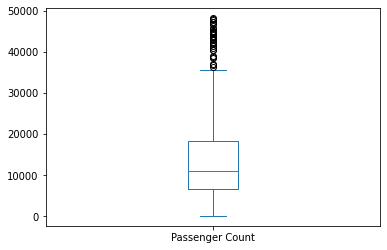

In [ ]:
myFig = plt.figure();
bp = pandas_data_passenger_europe["Passenger Count"].plot.box();
myFig.savefig(data_path + "europe_passenger_count_boxplot.png", format="png")

Central America

In [ ]:
data_passenger_central_america = data.filter(data['GEO Region']=='Central America').select('Passenger Count')
data_passenger_central_america.show()

+---------------+
|Passenger Count|
+---------------+
|           6324|
|           7031|
|           7357|
|           5128|
|           3790|
|           3529|
|           3527|
|           4037|
|           4105|
|           4259|
|           5371|
|           7536|
|           6237|
|           5321|
|           4176|
|           3938|
|           4436|
|           4395|
|           4518|
|           4418|
+---------------+
only showing top 20 rows



In [ ]:
pandas_data_passenger_central_america = data_passenger_central_america.toPandas()
pandas_data_passenger_central_america

,Passenger Count
0,6324
1,7031
2,7357
3,5128
4,3790
...,...
269,4741
270,3723
271,4173
272,5186


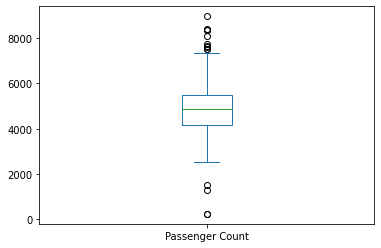

In [ ]:
myFig = plt.figure();
bp = pandas_data_passenger_central_america["Passenger Count"].plot.box();
myFig.savefig(data_path + "central_america_count_boxplot.png", format="png")

US

In [ ]:
data_passenger_us = data.filter(data['GEO Region']=='US').select('Passenger Count')
data_passenger_us.show()

+---------------+
|Passenger Count|
+---------------+
|          27271|
|          29131|
|           5415|
|           8055|
|           7984|
|          36641|
|          39379|
|           3678|
|         166577|
|         160890|
|           5493|
|           5213|
|           1552|
|           1484|
|          97510|
|          93791|
|          19234|
|          18368|
|           7579|
|           7658|
+---------------+
only showing top 20 rows



In [ ]:
pandas_data_passenger_us = data_passenger_us.toPandas()
pandas_data_passenger_us

,Passenger Count
0,27271
1,29131
2,5415
3,8055
4,7984
...,...
5792,327187
5793,319873
5794,39
5795,186464


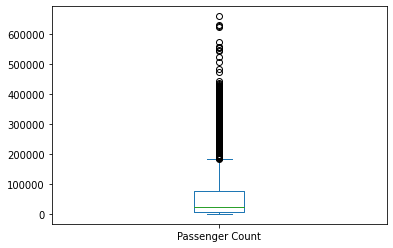

In [ ]:
myFig = plt.figure();
bp = pandas_data_passenger_us["Passenger Count"].plot.box();
myFig.savefig(data_path + "us_passenger_count_boxplot.png", format="png")

South America

In [ ]:
data_passenger_south_america = data.filter(data['GEO Region']=='South America').select('Passenger Count')
data_passenger_south_america.show()

+---------------+
|Passenger Count|
+---------------+
|           3400|
|           3030|
|           3257|
|           2807|
|           2799|
|           2612|
|           3133|
|           3120|
|           2769|
|           3310|
|           2949|
|           3285|
|           3685|
|           2882|
|           2940|
|           2954|
|           3218|
|           3485|
|           2558|
|           3100|
+---------------+
only showing top 20 rows



In [ ]:
pandas_data_passenger_south_america = data_passenger_south_america.toPandas()
pandas_data_passenger_south_america

,Passenger Count
0,3400
1,3030
2,3257
3,2807
4,2799
...,...
85,2598
86,2152
87,2612
88,2578


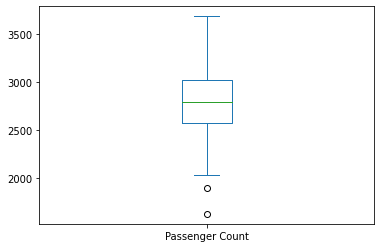

In [ ]:
myFig = plt.figure();
bp = pandas_data_passenger_south_america["Passenger Count"].plot.box();
myFig.savefig(data_path + "south_america_passenger_count_boxplot.png", format="png")

Mexico

In [ ]:
data_passenger_mexico = data.filter(data['GEO Region']=='Mexico').select('Passenger Count')
data_passenger_mexico.show()

+---------------+
|Passenger Count|
+---------------+
|           6969|
|          10046|
|           2266|
|           7751|
|           7845|
|           9537|
|           9672|
|             45|
|           7541|
|           9333|
|           1902|
|           7156|
|           5946|
|           9397|
|           9275|
|             78|
|           5446|
|           7674|
|           1504|
|           3986|
+---------------+
only showing top 20 rows



In [ ]:
pandas_data_passenger_mexico = data_passenger_mexico.toPandas()
pandas_data_passenger_mexico

,Passenger Count
0,6969
1,10046
2,2266
3,7751
4,7845
...,...
1110,8581
1111,914
1112,17521
1113,4189


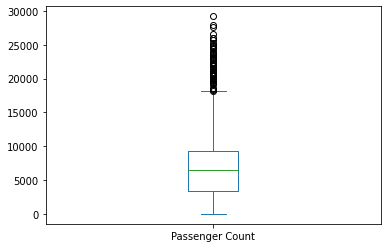

In [ ]:
myFig = plt.figure();
bp = pandas_data_passenger_mexico["Passenger Count"].plot.box();
myFig.savefig(data_path + "mexico_passenger_count_boxplot.png", format="png")

Middle East

In [ ]:
data_passenger_m_east = data.filter(data['GEO Region']=='Middle East').select('Passenger Count')
data_passenger_m_east.show()

+---------------+
|Passenger Count|
+---------------+
|           1147|
|           1766|
|           3393|
|           2470|
|           2502|
|           2278|
|           3353|
|           2704|
|           3342|
|           3048|
|           6243|
|           5875|
|           6604|
|           7803|
|           7948|
|           7135|
|           8133|
|           6104|
|           5819|
|           5841|
+---------------+
only showing top 20 rows



In [ ]:
pandas_data_passenger_m_east = data_passenger_m_east.toPandas()
pandas_data_passenger_m_east

,Passenger Count
0,1147
1,1766
2,3393
3,2470
4,2502
...,...
209,4591
210,13760
211,11503
212,7099


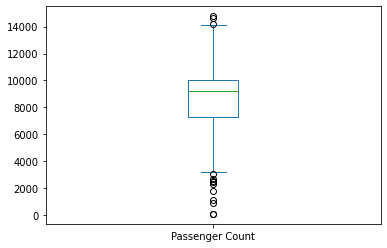

In [ ]:
myFig = plt.figure();
bp = pandas_data_passenger_m_east["Passenger Count"].plot.box();
myFig.savefig(data_path + "m_east_passenger_count_boxplot.png", format="png")

Canada

In [ ]:
data_passenger_canada = data.filter(data['GEO Region']=='Canada').select('Passenger Count')
data_passenger_canada.show()

+---------------+
|Passenger Count|
+---------------+
|          35156|
|          34090|
|           7977|
|           8837|
|           3688|
|           3633|
|          12874|
|          12085|
|             10|
|           2480|
|           2211|
|          34878|
|          34105|
|           8901|
|           9020|
|           3672|
|           3570|
|          13895|
|          12145|
|           2300|
+---------------+
only showing top 20 rows



In [ ]:
pandas_data_passenger_canada = data_passenger_canada.toPandas()
pandas_data_passenger_canada

,Passenger Count
0,35156
1,34090
2,7977
3,8837
4,3688
...,...
1413,344
1414,6842
1415,3805
1416,4388


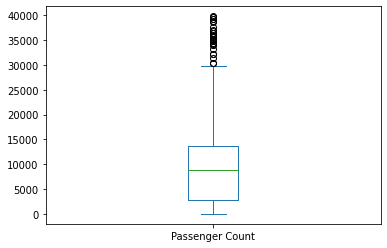

In [ ]:
myFig = plt.figure();
bp = pandas_data_passenger_canada["Passenger Count"].plot.box();
myFig.savefig(data_path + "canada_passenger_count_boxplot.png", format="png")

Australia / Oceania

In [ ]:
data_passenger_australia_oceania = data.filter(data['GEO Region']=='Australia / Oceania').select('Passenger Count')
data_passenger_australia_oceania.show()

+---------------+
|Passenger Count|
+---------------+
|           4998|
|           4962|
|           8603|
|           8234|
|           1385|
|           4672|
|           4006|
|           8903|
|           7874|
|           1475|
|           4565|
|           4295|
|           8048|
|           7750|
|           1264|
|           3178|
|           4766|
|           6280|
|           9056|
|           1046|
+---------------+
only showing top 20 rows



In [ ]:
pandas_data_passenger_australia_oceania = data_passenger_australia_oceania.toPandas()
pandas_data_passenger_australia_oceania

,Passenger Count
0,4998
1,4962
2,8603
3,8234
4,1385
...,...
732,8453
733,7136
734,5329
735,7593


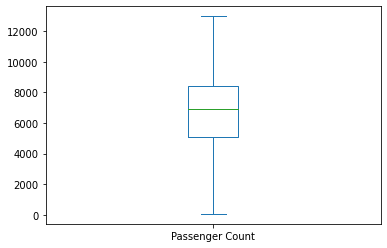

In [ ]:
myFig = plt.figure();
bp = pandas_data_passenger_australia_oceania["Passenger Count"].plot.box();
myFig.savefig(data_path + "australia_oceania_passenger_count_boxplot.png", format="png")

Asia

In [ ]:
data_passenger_asia = data.filter(data['GEO Region']=='Asia').select('Passenger Count')
data_passenger_asia.show()

+---------------+
|Passenger Count|
+---------------+
|           6263|
|           5500|
|           6545|
|           6094|
|           5041|
|           4744|
|          11010|
|           9628|
|          13638|
|          11255|
|          14142|
|          12132|
|           9195|
|           9086|
|           6153|
|           5646|
|           7229|
|           6554|
|          12828|
|          10269|
+---------------+
only showing top 20 rows



In [ ]:
pandas_data_passenger_asia = data_passenger_asia.toPandas()
pandas_data_passenger_asia

,Passenger Count
0,6263
1,5500
2,6545
3,6094
4,5041
...,...
3268,9904
3269,11807
3270,13553
3271,67286


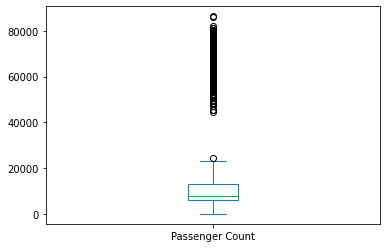

In [ ]:
myFig = plt.figure();
bp = pandas_data_passenger_asia["Passenger Count"].plot.box();
myFig.savefig(data_path + "asia_passenger_count_boxplot.png", format="png")

# **Boxplot***** Adjusted Passenger Count**

Europe

In [ ]:
data_adjusted_passenger_europe = data.filter(data['GEO Region']=='Europe').select('Adjusted Passenger Count')
data_adjusted_passenger_europe.show()

+------------------------+
|Adjusted Passenger Count|
+------------------------+
|                   12050|
|                   11638|
|                     325|
|                     545|
|                   20632|
|                   21686|
|                    4540|
|                    4341|
|                    9978|
|                    9587|
|                   22389|
|                   20511|
|                   30796|
|                   29283|
|                    1776|
|                   11684|
|                   10771|
|                   11230|
|                   11731|
|                     353|
+------------------------+
only showing top 20 rows



In [ ]:
pandas_data_adjusted_passenger_europe = data_adjusted_passenger_europe.toPandas()
pandas_data_adjusted_passenger_europe

,Adjusted Passenger Count
0,12050
1,11638
2,325
3,545
4,20632
...,...
2084,8729
2085,20876
2086,19711
2087,12313


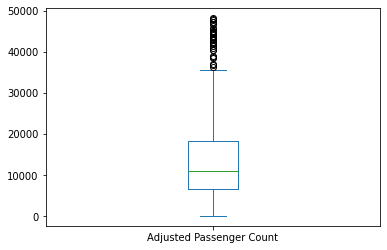

In [ ]:
myFig = plt.figure();
bp = pandas_data_adjusted_passenger_europe["Adjusted Passenger Count"].plot.box();
myFig.savefig(data_path + "europe_adjusted_passenger_count_boxplot.png", format="png")

Central America

In [ ]:
data_adjusted_passenger_central_america = data.filter(data['GEO Region']=='Central America').select('Adjusted Passenger Count')
data_adjusted_passenger_central_america.show()

+------------------------+
|Adjusted Passenger Count|
+------------------------+
|                    6324|
|                    7031|
|                    7357|
|                    5128|
|                    3790|
|                    3529|
|                    3527|
|                    4037|
|                    4105|
|                    4259|
|                    5371|
|                    7536|
|                    6237|
|                    5321|
|                    4176|
|                    3938|
|                    4436|
|                    4395|
|                    4518|
|                    4418|
+------------------------+
only showing top 20 rows



In [ ]:
pandas_data_adjusted_passenger_central_america = data_adjusted_passenger_central_america.toPandas()
pandas_data_adjusted_passenger_central_america

,Adjusted Passenger Count
0,6324
1,7031
2,7357
3,5128
4,3790
...,...
269,4741
270,3723
271,4173
272,5186


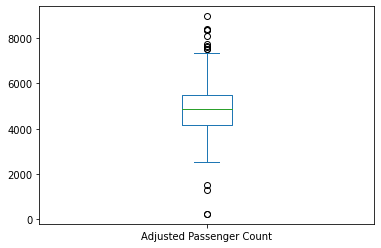

In [ ]:
myFig = plt.figure();
bp = pandas_data_adjusted_passenger_central_america["Adjusted Passenger Count"].plot.box();
myFig.savefig(data_path + "central_america_adjusted_passenger_count_boxplot.png", format="png")

US

In [ ]:
data_adjusted_passenger_us = data.filter(data['GEO Region']=='US').select('Adjusted Passenger Count')
data_adjusted_passenger_us.show()

+------------------------+
|Adjusted Passenger Count|
+------------------------+
|                   27271|
|                   29131|
|                   10830|
|                    8055|
|                    7984|
|                   36641|
|                   39379|
|                    7356|
|                  166577|
|                  160890|
|                    5493|
|                    5213|
|                    1552|
|                    1484|
|                   97510|
|                   93791|
|                   19234|
|                   18368|
|                    7579|
|                    7658|
+------------------------+
only showing top 20 rows



In [ ]:
pandas_data_adjusted_passenger_us = data_adjusted_passenger_us.toPandas()
pandas_data_adjusted_passenger_us

,Adjusted Passenger Count
0,27271
1,29131
2,10830
3,8055
4,7984
...,...
5792,327187
5793,319873
5794,78
5795,186464


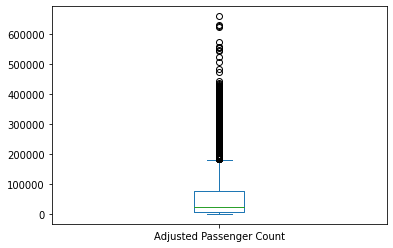

In [ ]:
myFig = plt.figure();
bp = pandas_data_adjusted_passenger_us["Adjusted Passenger Count"].plot.box();
myFig.savefig(data_path + "us_adjusted_passenger_count_boxplot.png", format="png")

South America

In [ ]:
data_adjusted_passenger_south_america = data.filter(data['GEO Region']=='South America').select('Adjusted Passenger Count')
data_adjusted_passenger_south_america.show()

+------------------------+
|Adjusted Passenger Count|
+------------------------+
|                    3400|
|                    3030|
|                    3257|
|                    2807|
|                    2799|
|                    2612|
|                    3133|
|                    3120|
|                    2769|
|                    3310|
|                    2949|
|                    3285|
|                    3685|
|                    2882|
|                    2940|
|                    2954|
|                    3218|
|                    3485|
|                    2558|
|                    3100|
+------------------------+
only showing top 20 rows



In [ ]:
pandas_data_adjusted_passenger_south_america = data_adjusted_passenger_south_america.toPandas()
pandas_data_adjusted_passenger_south_america

,Adjusted Passenger Count
0,3400
1,3030
2,3257
3,2807
4,2799
...,...
85,2598
86,2152
87,2612
88,2578


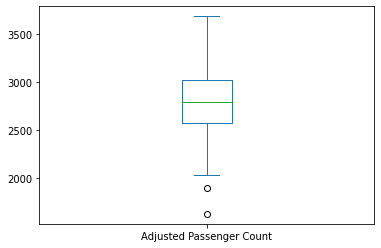

In [ ]:
myFig = plt.figure();
bp = pandas_data_adjusted_passenger_south_america["Adjusted Passenger Count"].plot.box();
myFig.savefig(data_path + "south_america_adjusted_passenger_count_boxplot.png", format="png")

Mexico

In [ ]:
data_adjusted_passenger_mexico = data.filter(data['GEO Region']=='Mexico').select('Adjusted Passenger Count')
data_adjusted_passenger_mexico.show()

+------------------------+
|Adjusted Passenger Count|
+------------------------+
|                    6969|
|                   10046|
|                    4532|
|                    7751|
|                    7845|
|                    9537|
|                    9672|
|                      90|
|                    7541|
|                    9333|
|                    3804|
|                    7156|
|                    5946|
|                    9397|
|                    9275|
|                     156|
|                    5446|
|                    7674|
|                    3008|
|                    3986|
+------------------------+
only showing top 20 rows



In [ ]:
pandas_data_adjusted_passenger_mexico = data_adjusted_passenger_mexico.toPandas()
pandas_data_adjusted_passenger_mexico

,Adjusted Passenger Count
0,6969
1,10046
2,4532
3,7751
4,7845
...,...
1110,8581
1111,914
1112,17521
1113,4189


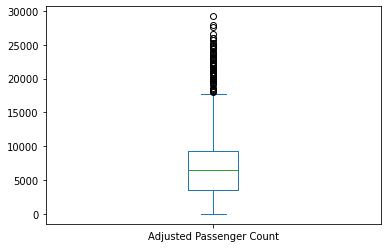

In [ ]:
myFig = plt.figure();
bp = pandas_data_adjusted_passenger_mexico["Adjusted Passenger Count"].plot.box();
myFig.savefig(data_path + "mexico_adjusted_passenger_count_boxplot.png", format="png")

Middle East

In [ ]:
data_adjusted_passenger_m_east = data.filter(data['GEO Region']=='Middle East').select('Adjusted Passenger Count')
data_adjusted_passenger_m_east.show()

+------------------------+
|Adjusted Passenger Count|
+------------------------+
|                    1147|
|                    1766|
|                    3393|
|                    2470|
|                    2502|
|                    2278|
|                    3353|
|                    2704|
|                    3342|
|                    3048|
|                    6243|
|                    5875|
|                    6604|
|                    7803|
|                    7948|
|                    7135|
|                    8133|
|                    6104|
|                    5819|
|                    5841|
+------------------------+
only showing top 20 rows



In [ ]:
pandas_data_adjusted_passenger_m_east = data_adjusted_passenger_m_east.toPandas()
pandas_data_adjusted_passenger_m_east

,Adjusted Passenger Count
0,1147
1,1766
2,3393
3,2470
4,2502
...,...
209,4591
210,13760
211,11503
212,7099


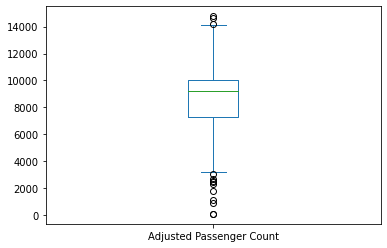

In [ ]:
myFig = plt.figure();
bp = pandas_data_adjusted_passenger_m_east["Adjusted Passenger Count"].plot.box();
myFig.savefig(data_path + "m_east_adjusted_passenger_count_boxplot.png", format="png")

Canada

In [ ]:
data_adjusted_passenger_canada = data.filter(data['GEO Region']=='Canada').select('Adjusted Passenger Count')
data_adjusted_passenger_canada.show()

+------------------------+
|Adjusted Passenger Count|
+------------------------+
|                   35156|
|                   34090|
|                    7977|
|                    8837|
|                    3688|
|                    3633|
|                   12874|
|                   12085|
|                      20|
|                    2480|
|                    2211|
|                   34878|
|                   34105|
|                    8901|
|                    9020|
|                    3672|
|                    3570|
|                   13895|
|                   12145|
|                    2300|
+------------------------+
only showing top 20 rows



In [ ]:
pandas_data_adjusted_passenger_canada = data_adjusted_passenger_canada.toPandas()
pandas_data_adjusted_passenger_canada

,Adjusted Passenger Count
0,35156
1,34090
2,7977
3,8837
4,3688
...,...
1413,344
1414,6842
1415,3805
1416,4388


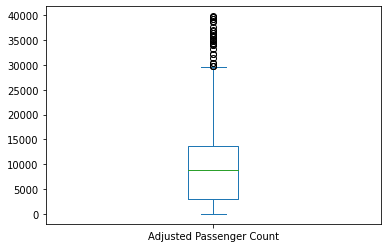

In [ ]:
myFig = plt.figure();
bp = pandas_data_adjusted_passenger_canada["Adjusted Passenger Count"].plot.box();
myFig.savefig(data_path + "canada_adjusted_passenger_count_boxplot.png", format="png")

Australia / Oceania

In [ ]:
data_adjusted_passenger_australia_oceania = data.filter(data['GEO Region']=='Australia / Oceania').select('Adjusted Passenger Count')
data_adjusted_passenger_australia_oceania.show()

+------------------------+
|Adjusted Passenger Count|
+------------------------+
|                    4998|
|                    4962|
|                    8603|
|                    8234|
|                    2770|
|                    4672|
|                    4006|
|                    8903|
|                    7874|
|                    2950|
|                    4565|
|                    4295|
|                    8048|
|                    7750|
|                    2528|
|                    3178|
|                    4766|
|                    6280|
|                    9056|
|                    2092|
+------------------------+
only showing top 20 rows



In [ ]:
pandas_data_adjusted_passenger_australia_oceania = data_adjusted_passenger_australia_oceania.toPandas()
pandas_data_adjusted_passenger_australia_oceania

,Adjusted Passenger Count
0,4998
1,4962
2,8603
3,8234
4,2770
...,...
732,8453
733,7136
734,5329
735,7593


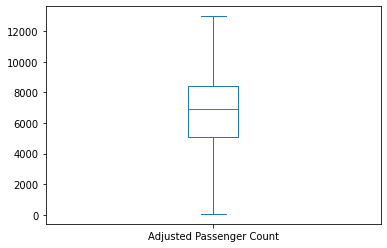

In [ ]:
myFig = plt.figure();
bp = pandas_data_adjusted_passenger_australia_oceania["Adjusted Passenger Count"].plot.box();
myFig.savefig(data_path + "australia_oceania_adjusted_passenger_count_boxplot.png", format="png")

Asia

In [ ]:
data_adjusted_passenger_asia = data.filter(data['GEO Region']=='Asia').select('Adjusted Passenger Count')
data_adjusted_passenger_asia.show()

+------------------------+
|Adjusted Passenger Count|
+------------------------+
|                    6263|
|                    5500|
|                    6545|
|                    6094|
|                    5041|
|                    4744|
|                   11010|
|                    9628|
|                   13638|
|                   11255|
|                   14142|
|                   12132|
|                    9195|
|                    9086|
|                    6153|
|                    5646|
|                    7229|
|                    6554|
|                   12828|
|                   10269|
+------------------------+
only showing top 20 rows



In [ ]:
pandas_data_adjusted_passenger_asia = data_adjusted_passenger_asia.toPandas()
pandas_data_adjusted_passenger_asia

,Adjusted Passenger Count
0,6263
1,5500
2,6545
3,6094
4,5041
...,...
3268,9904
3269,11807
3270,13553
3271,67286


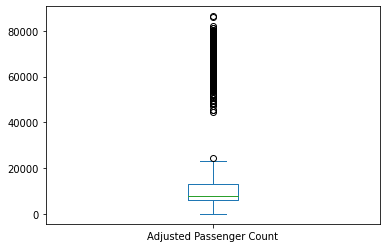

In [ ]:
myFig = plt.figure();
bp = pandas_data_adjusted_passenger_asia["Adjusted Passenger Count"].plot.box();
myFig.savefig(data_path + "asia_adjusted_passenger_count_boxplot.png", format="png")

# ***correlación***

In [ ]:
data.show(5)

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+----------+------------------+-------------------+----------+-------------+---------------+---------------------------+------------------------+----+-----+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|GEO Region|Activity Type Code|Price Category Code|  Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+----------+------------------+-------------------+----------+-------------+---------------+---------------------------+------------------------+----+-----+
|         200507|     ATA Airlines|                         TZ|     ATA Airlines|                         TZ|     Domestic|        US|          Deplaned|          

In [ ]:
data.count()

15007

In [ ]:
columnas_listas=list(data.columns)

In [ ]:
columnas_numericas=['Activity Period','Passenger Count', 'Adjusted Passenger Count','Year' ]

In [ ]:
from pyspark.sql import functions as F

In [ ]:
data_numericas = data.select(*(F.col(c).cast('Double').alias(c) for c in columnas_numericas))
data_numericas.dtypes

[('Activity Period', 'double'),
 ('Passenger Count', 'double'),
 ('Adjusted Passenger Count', 'double'),
 ('Year', 'double')]

In [ ]:
data_numericas.dtypes

[('Activity Period', 'double'),
 ('Passenger Count', 'double'),
 ('Adjusted Passenger Count', 'double'),
 ('Year', 'double')]

In [ ]:
data_numericas.show()

+---------------+---------------+------------------------+------+
|Activity Period|Passenger Count|Adjusted Passenger Count|  Year|
+---------------+---------------+------------------------+------+
|       200507.0|        27271.0|                 27271.0|2005.0|
|       200507.0|        29131.0|                 29131.0|2005.0|
|       200507.0|         5415.0|                 10830.0|2005.0|
|       200507.0|        35156.0|                 35156.0|2005.0|
|       200507.0|        34090.0|                 34090.0|2005.0|
|       200507.0|         6263.0|                  6263.0|2005.0|
|       200507.0|         5500.0|                  5500.0|2005.0|
|       200507.0|        12050.0|                 12050.0|2005.0|
|       200507.0|        11638.0|                 11638.0|2005.0|
|       200507.0|         4998.0|                  4998.0|2005.0|
|       200507.0|         4962.0|                  4962.0|2005.0|
|       200507.0|         8055.0|                  8055.0|2005.0|
|       20

In [ ]:
data_numericas.count()

15007

In [ ]:
data_pandas=data_numericas.toPandas()
data_pandas.head()

,Activity Period,Passenger Count,Adjusted Passenger Count,Year
0,200507.0,27271.0,27271.0,2005.0
1,200507.0,29131.0,29131.0,2005.0
2,200507.0,5415.0,10830.0,2005.0
3,200507.0,35156.0,35156.0,2005.0
4,200507.0,34090.0,34090.0,2005.0


In [ ]:
corr_pearson=data_pandas.corr(method='pearson')
corr_pearson

,Activity Period,Passenger Count,Adjusted Passenger Count,Year
Activity Period,1.000000,0.060311,0.059336,0.999940
Passenger Count,0.060311,1.000000,0.999941,0.060069
Adjusted Passenger Count,0.059336,0.999941,1.000000,0.059096
Year,0.999940,0.060069,0.059096,1.000000


----------------------MAPA DE CALOR-------------------------------

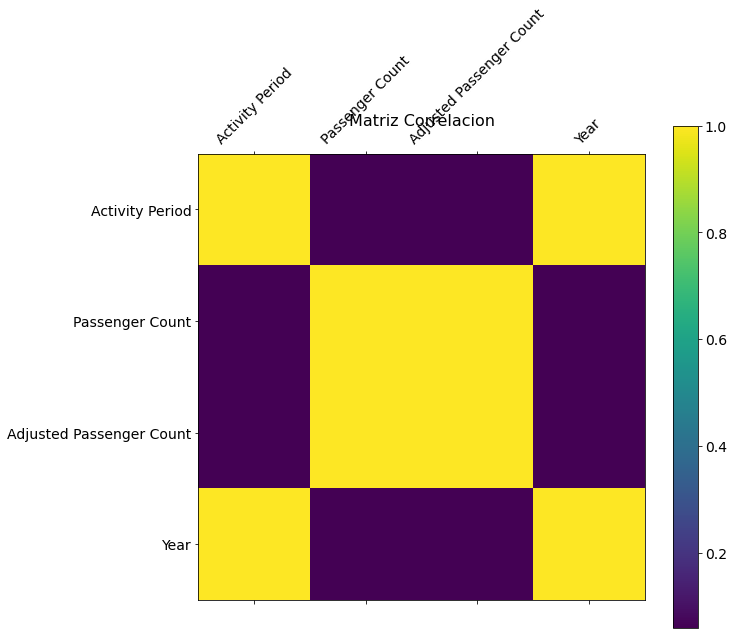

In [ ]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 9))
plt.matshow(data_pandas.corr(), fignum=f.number)
plt.xticks(range(data_pandas.shape[1]), data_pandas.columns, fontsize=14, rotation=45)
plt.yticks(range(data_pandas.shape[1]), data_pandas.columns, fontsize=14)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Matriz Correlacion', fontsize=16)
plt.show()

Activity Period

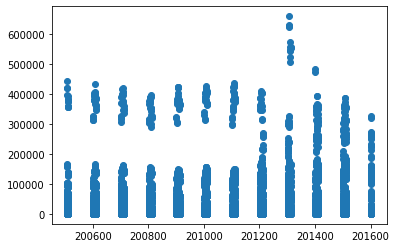

In [ ]:
from matplotlib import pyplot
pyplot.scatter(data_pandas['Activity Period'], data_pandas['Adjusted Passenger Count'])
pyplot.show()

Year

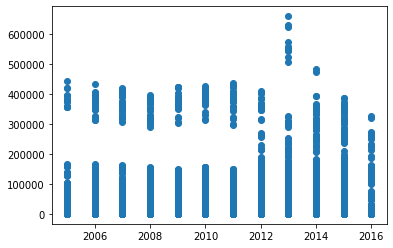

In [ ]:
from matplotlib import pyplot
pyplot.scatter(data_pandas['Year'], data_pandas['Adjusted Passenger Count'])
pyplot.show()

## ***algoritmo de regresion lineal***

In [ ]:
data.select('Month').distinct().show()

+---------+
|    Month|
+---------+
|     July|
| November|
| February|
|  January|
|    March|
|  October|
|      May|
|   August|
|    April|
|     June|
| December|
|September|
+---------+



convertir los meses de string a numericos

In [ ]:
import pyspark.sql.functions as sql_functions
from pyspark.sql.functions import when
from pyspark.sql.types import IntegerType

In [ ]:
def month_to_number(Month):
    if month == "January":
        return 1
    elif month == "February":
        return 2
    elif month == "March":
        return 3
    elif month == "April":
        return 4
    elif month == "May":
        return 5
    elif month == "June":
        return 6
    elif month == "July":
        return 7
    elif month == "August":
        return 8
    elif month == "September":
        return 9
    elif month == "October":
        return 10
    elif month == "November":
        return 11
    elif month == "December":
        return 12

In [ ]:
data = data.withColumn ("month_num", when(data["Month"] == "January",1).when(data["Month"] == "February",2).when(data["Month"] == "March",3).when(data["Month"] == "April",4).when(data["Month"] == "May",5).when(data["Month"] == "June",6).when(data["Month"] == "July",7).when(data["Month"] == "August",8).when(data["Month"] == "September",9).when(data["Month"] == "October",10).when(data["Month"] == "November",11).when(data["Month"] == "December",12).cast(IntegerType()))

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

queda generada la nueva columna:

In [ ]:
data.show(5)

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+----------+------------------+-------------------+----------+-------------+---------------+---------------------------+------------------------+----+-----+---------+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|GEO Region|Activity Type Code|Price Category Code|  Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|month_num|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+----------+------------------+-------------------+----------+-------------+---------------+---------------------------+------------------------+----+-----+---------+
|         200507|     ATA Airlines|                         TZ|     ATA Airlines|                         TZ|     Domestic|        US

In [ ]:
data.printSchema() # Información sobre qué tipo de variable es cada columna

root
 |-- Activity Period: integer (nullable = true)
 |-- Operating Airline: string (nullable = true)
 |-- Operating Airline IATA Code: string (nullable = true)
 |-- Published Airline: string (nullable = true)
 |-- Published Airline IATA Code: string (nullable = true)
 |-- GEO Summary: string (nullable = true)
 |-- GEO Region: string (nullable = true)
 |-- Activity Type Code: string (nullable = true)
 |-- Price Category Code: string (nullable = true)
 |-- Terminal: string (nullable = true)
 |-- Boarding Area: string (nullable = true)
 |-- Passenger Count: integer (nullable = true)
 |-- Adjusted Activity Type Code: string (nullable = true)
 |-- Adjusted Passenger Count: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- month_num: integer (nullable = true)



In [ ]:
data_model = data.select("Adjusted Passenger Count", "Year", "month")
data_model.show(5)

+------------------------+----+-----+
|Adjusted Passenger Count|Year|month|
+------------------------+----+-----+
|                   27271|2005| July|
|                   29131|2005| July|
|                   10830|2005| July|
|                   35156|2005| July|
|                   34090|2005| July|
+------------------------+----+-----+
only showing top 5 rows



In [ ]:
data_model.dtypes # Tipo de variables (enteras)

[('Adjusted Passenger Count', 'int'), ('Year', 'int'), ('month', 'string')]

In [ ]:
categorical_cols = ["Year", "month"]
numerical_cols = ["Adjusted Passenger Count"]

In [ ]:
# Se muestra el número de meses y años diferentes que hay en la base de datos (categorías)
data_model.agg(sql_functions.countDistinct("Year")).show()
data_model.agg(sql_functions.countDistinct("month")).show()

+-----------+
|count(Year)|
+-----------+
|         12|
+-----------+

+------------+
|count(month)|
+------------+
|          12|
+------------+



In [ ]:
data_model.groupBy("month").count().show() # Número de veces que aparece info de cada mes
data_model.groupBy("Year").count().show() # Número de veces que aparece info de cada año

+---------+-----+
|    month|count|
+---------+-----+
|     July| 1303|
| November| 1263|
| February| 1255|
|  January| 1268|
|    March| 1253|
|  October| 1295|
|      May| 1172|
|   August| 1310|
|    April| 1149|
|     June| 1183|
| December| 1259|
|September| 1297|
+---------+-----+

+----+-----+
|Year|count|
+----+-----+
|2007| 1409|
|2015| 1460|
|2006| 1369|
|2013| 1358|
|2014| 1368|
|2012| 1378|
|2009| 1393|
|2016|  371|
|2005|  695|
|2010| 1383|
|2011| 1390|
|2008| 1433|
+----+-----+



In [ ]:
# ONE HOT ENCODING: Se utiliza para transformar las columnas categóricas a DUMMY (0-1)
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [ ]:
for col in categorical_cols:
  indexer = StringIndexer(inputCol=col, outputCol=col + "_StringIndexer")
  model = indexer.fit(data_model)
  indexed_data = model.transform(data_model)

  # OneHotEncoder
  encoder = OneHotEncoder(inputCol=col + "_StringIndexer", outputCol=col + "_vec")
  onehotenc = encoder.fit(indexed_data)
  data_model = onehotenc.transform(indexed_data)

In [ ]:
data_model.show(5)

+------------------------+----+-----+------------------+---------------+-------------------+--------------+
|Adjusted Passenger Count|Year|month|Year_StringIndexer|       Year_vec|month_StringIndexer|     month_vec|
+------------------------+----+-----+------------------+---------------+-------------------+--------------+
|                   27271|2005| July|              10.0|(11,[10],[1.0])|                1.0|(11,[1],[1.0])|
|                   29131|2005| July|              10.0|(11,[10],[1.0])|                1.0|(11,[1],[1.0])|
|                   10830|2005| July|              10.0|(11,[10],[1.0])|                1.0|(11,[1],[1.0])|
|                   35156|2005| July|              10.0|(11,[10],[1.0])|                1.0|(11,[1],[1.0])|
|                   34090|2005| July|              10.0|(11,[10],[1.0])|                1.0|(11,[1],[1.0])|
+------------------------+----+-----+------------------+---------------+-------------------+--------------+
only showing top 5 rows



In [ ]:
# VectorAssembler se utiliza para concatenar todas las variables (numérica+categóricas)
from pyspark.ml.feature import VectorAssembler

In [ ]:
assembler = VectorAssembler(inputCols=["month_vec", "Year_vec", "Adjusted Passenger Count"], outputCol="features")
data_model = assembler.transform(data_model)

In [ ]:
data_model.show()

+------------------------+----+-----+------------------+---------------+-------------------+--------------+--------------------+
|Adjusted Passenger Count|Year|month|Year_StringIndexer|       Year_vec|month_StringIndexer|     month_vec|            features|
+------------------------+----+-----+------------------+---------------+-------------------+--------------+--------------------+
|                   27271|2005| July|              10.0|(11,[10],[1.0])|                1.0|(11,[1],[1.0])|(23,[1,21,22],[1....|
|                   29131|2005| July|              10.0|(11,[10],[1.0])|                1.0|(11,[1],[1.0])|(23,[1,21,22],[1....|
|                   10830|2005| July|              10.0|(11,[10],[1.0])|                1.0|(11,[1],[1.0])|(23,[1,21,22],[1....|
|                   35156|2005| July|              10.0|(11,[10],[1.0])|                1.0|(11,[1],[1.0])|(23,[1,21,22],[1....|
|                   34090|2005| July|              10.0|(11,[10],[1.0])|                1.0|(11,[

In [ ]:
# train, test = data_model.randomSplit([0.8, 0.2], seed=42)
total_data = data_model.count()
train = data_model.limit(int(0.8*total_data))
test = data_model.exceptAll(train)

In [ ]:
print("Longitud del conjunto de datos Train:", train.count())
print("Longitud del conjunto de datos Test:", test.count())

Longitud del conjunto de datos Train: 12005
Longitud del conjunto de datos Test: 3002


In [ ]:
test.show()

+------------------------+----+---------+------------------+--------------+-------------------+---------------+--------------------+
|Adjusted Passenger Count|Year|    month|Year_StringIndexer|      Year_vec|month_StringIndexer|      month_vec|            features|
+------------------------+----+---------+------------------+--------------+-------------------+---------------+--------------------+
|                    5457|2014|     June|               8.0|(11,[8],[1.0])|                9.0| (11,[9],[1.0])|(23,[9,19,22],[1....|
|                    9287|2014|September|               8.0|(11,[8],[1.0])|                2.0| (11,[2],[1.0])|(23,[2,19,22],[1....|
|                      51|2015| February|               0.0|(11,[0],[1.0])|                7.0| (11,[7],[1.0])|(23,[7,11,22],[1....|
|                    8411|2015|      May|               0.0|(11,[0],[1.0])|               10.0|(11,[10],[1.0])|(23,[10,11,22],[1...|
|                     546|2015|     July|               0.0|(11,[0],[

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
lr = LinearRegression(featuresCol="features", labelCol="Adjusted Passenger Count")
lr_model = lr.fit(train)

In [ ]:
predictions = lr_model.transform(test)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
evaluator = RegressionEvaluator(labelCol="Adjusted Passenger Count", predictionCol="prediction", metricName="rmse")

In [ ]:
# Calcula la métrica RMSE
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.0013697356856249942


In [ ]:
real = predictions.select("Adjusted Passenger Count").collect()
pred = predictions.select("prediction").collect()
x = predictions.select("Year").collect()

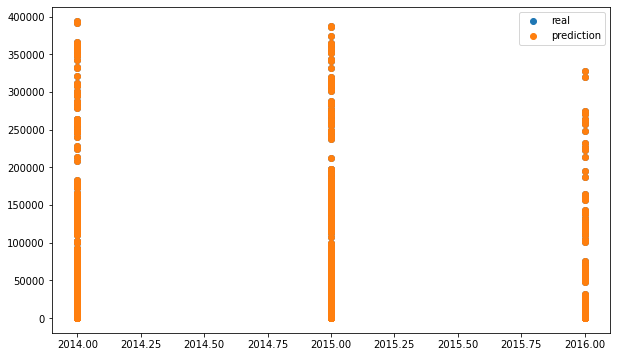

In [ ]:
# Dibujar un gráfico de líneas con los valores reales y predichos
plt.figure(figsize=(10, 6))
plt.scatter(x, real, label="real")
plt.scatter(x, pred, label="prediction")
plt.legend()
plt.show()